# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import time

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

## Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams

from src.feature_selection.functions import shap_feature_selection, process_fi

from src.utils.functions import adjust_fi

from src.model.functions import run_model_experiment

from src.plots.functions import plots_metrics

## Parameters

In [5]:
seed = 123
iterations = 10
gamma = 0.146
n_estimators_list = [25, 50, 75, 100, 125, 150, 175, 200]
np.random.seed(seed)

dataset_id = 'example'
df = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)

### Paths

In [6]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

## Features selected

### Generate/Load data

In [7]:
# Simulated data and settings
gamma, iterations = 0.146, 10

# Split the DataFrame into features (X) and target (y)
X = df.drop('y', axis=1)  # Features (all columns except 'y')
y = df['y']  # Target (the 'y' column)

# Split into training and testing sets
xtr, xte , ytr, yte = train_test_split(X, y, test_size=0.1, random_state=seed)

### Generate the model

In [8]:
# Initialize and train the IsolationForest model
model = IsolationForest(**hyper, random_state=seed)
model.fit(xtr)

IsolationForest(contamination=0.1, random_state=123)

### Features names

In [9]:
feature_names = np.array(X.columns.tolist())

### Selection process

In [10]:
# Example usage:
selected_features_df = shap_feature_selection(model, xtr, xte, feature_names, agnostic=False)
fi_shap_all = process_fi(selected_features_df, 10)
fi_shap_all.to_parquet(path_fi_shap)

In [11]:
fi_shap_all = pd.read_parquet(path_fi_shap)
fi_shap_all = adjust_fi(fi_shap_all)
fi_shap_all

,n_feats,cum_value,cum_value_percentage,n_feats_percentage,feat_selected
0,2,0.817763,49.580866,40.0,"[feature_2, feature_4]"
2,3,1.151545,69.817997,60.0,"[feature_2, feature_4, feature_3]"
3,4,1.438979,87.245099,80.0,"[feature_2, feature_4, feature_3, feature_1]"
4,5,1.649352,100.000000,100.0,"[feature_2, feature_4, feature_3, feature_1, f..."


### Generate data

In [12]:
# Capture the start time
start_time = datetime.datetime.now()

results = run_model_experiment(fi_shap_all, df, hyper, 
                     gamma=gamma, iterations=iterations, 
                     n_estimators_list=n_estimators_list, seed=seed, 
                     dataset_id=dataset_id)

# Capture the finish time
finish_time = datetime.datetime.now()

# Calculate the duration
duration = finish_time - start_time

print(f"Duration: {duration}")

Duration: 0:00:58.069054


In [13]:
results.to_parquet(path_shap)

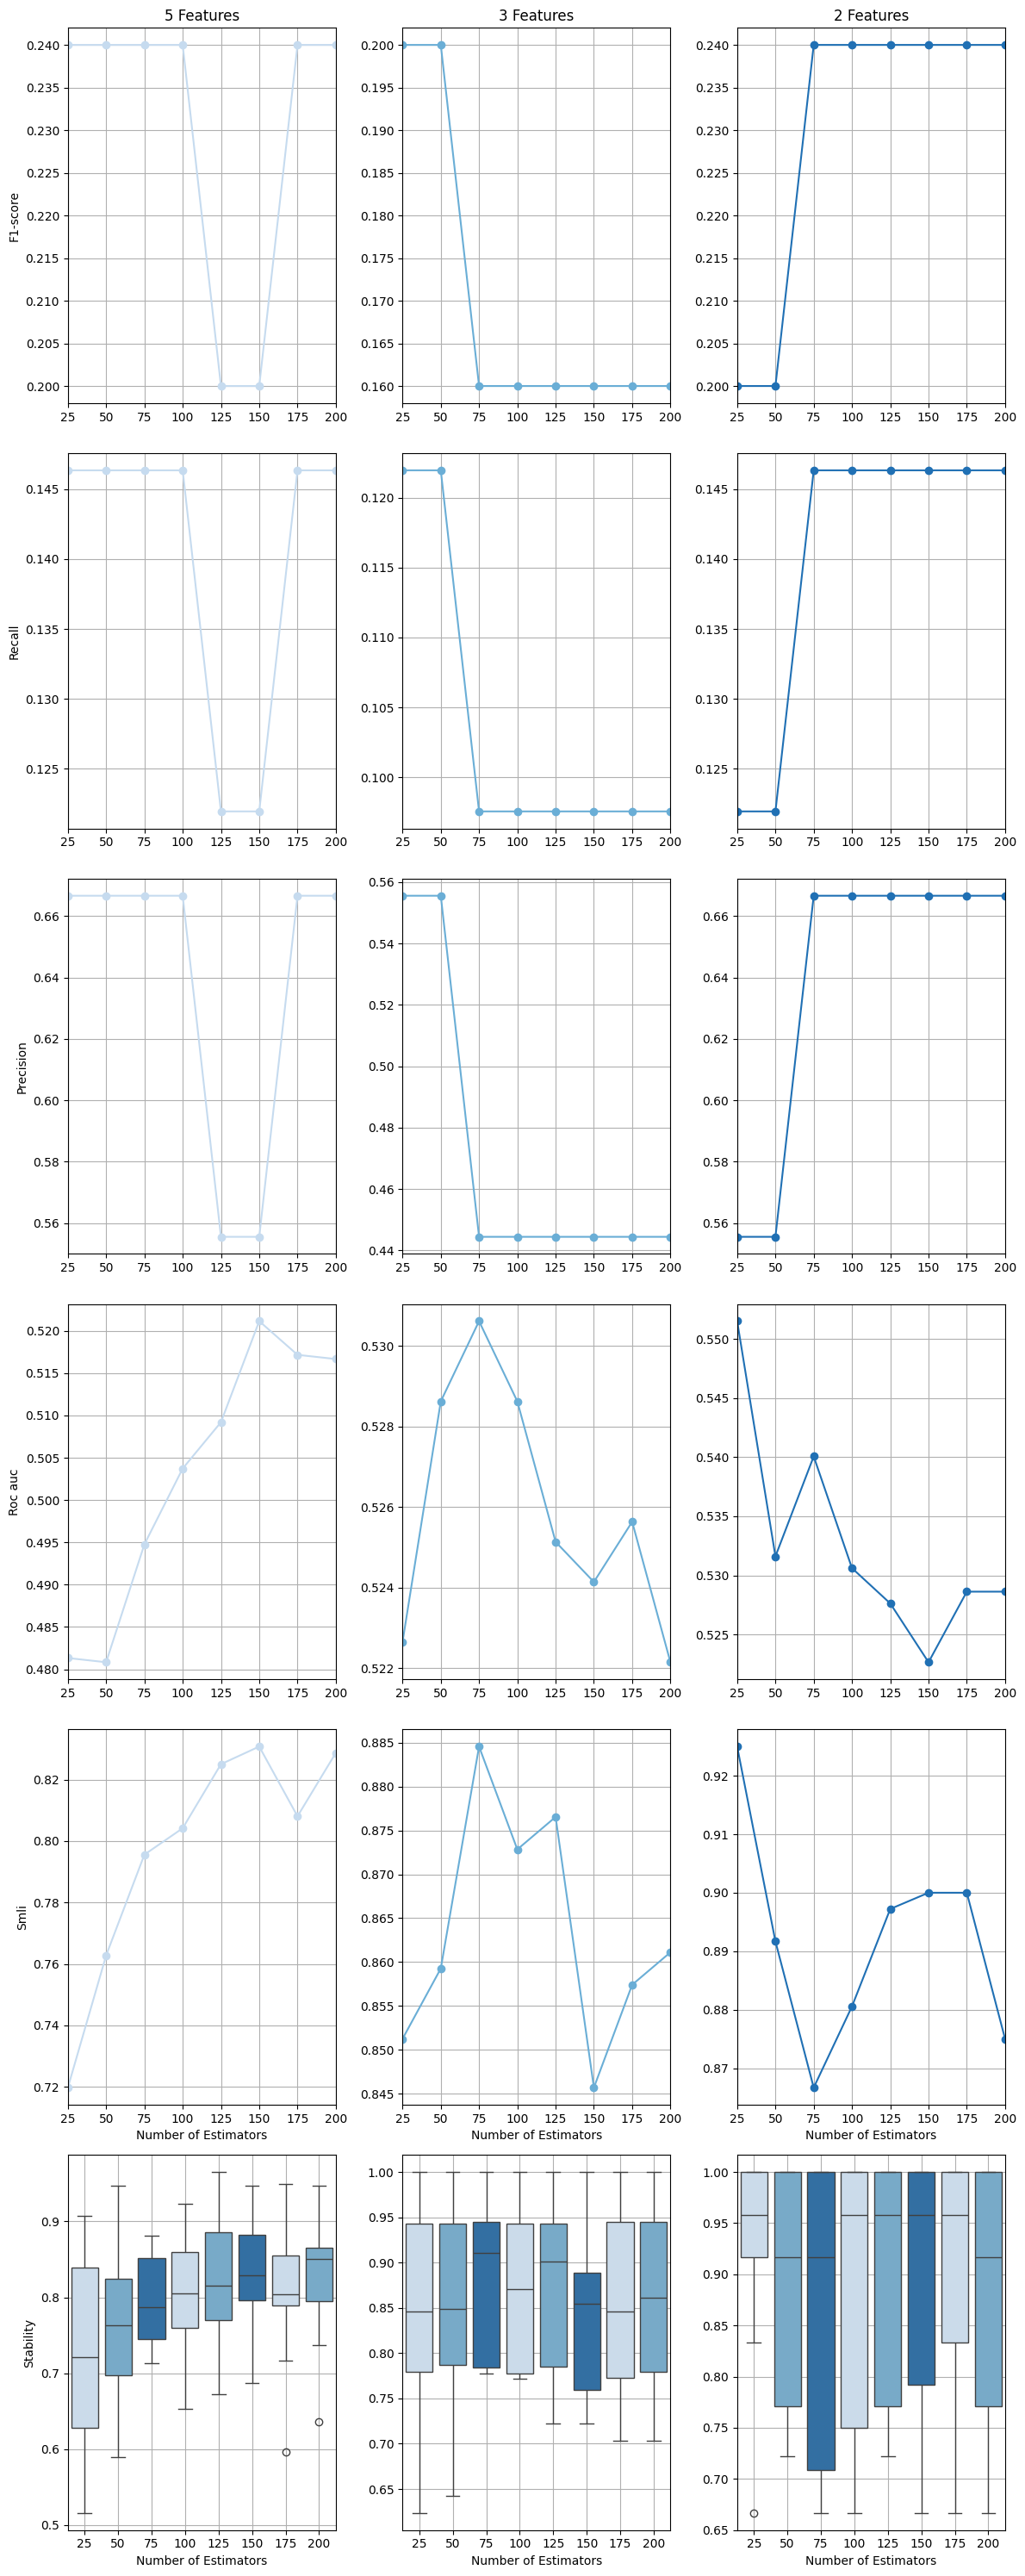

In [14]:
plots_metrics(results, 
              feat_imp=[100, 75, 50, 25],
              metrics_list=['f1-score', 'recall', 'precision', 'roc_auc', 'smli', 'smli_all'])